# Cheat Sheet

In [1]:
import numpy as np
import pandas as pd

from pystatplottools.pdf_env.loading_figure_mode import loading_figure_mode
fma, plt = loading_figure_mode(develop=True) # develop=False will export the generated figures as pngs into "./data/RectangleData"
plt.style.use('seaborn-dark-palette')

## pystatplottools.pytorch_data_generation - In Memory Dataset for a Custom Dataset

### Custom Data Generator

We start by defining a data generator for rectangles with a random unique color.

In [2]:
from pystatplottools.pytorch_data_generation.data_generation.datageneratorbaseclass import DataGeneratorBaseClass


class RectangleGenerator(DataGeneratorBaseClass):

    def __init__(self, **kwargs):
        super().__init__(**kwargs)

        self.inp_size = kwargs.pop("dim")
        self.tar_size = 2

        self.h, self.w = self.inp_size
        self.rectangle_hs = np.arange(1, self.h)
        self.rectangle_ws = np.arange(1, self.w)

    def sampler(self):
        rect_h = np.random.choice(self.rectangle_hs)
        rect_w = np.random.choice(self.rectangle_ws)
        sample = np.zeros((self.h, self.w))

        left_idx_h = np.random.randint(0, self.h - rect_h + 1, 1)[0]
        left_idx_w = np.random.randint(0, self.w - rect_w + 1, 1)[0]

        sample[left_idx_h:left_idx_h + rect_h, left_idx_w:left_idx_w + rect_w] = np.random.rand() * (rect_h / (left_idx_w + 1)) / self.h
        return sample, np.array([rect_h, rect_w])


class BatchRectangleGenerator(RectangleGenerator):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

        self.batch_size = kwargs.pop("batch_size")

    def sampler(self):
        rect_hs = np.random.choice(self.rectangle_hs, self.batch_size)
        rect_ws = np.random.choice(self.rectangle_ws, self.batch_size)
        batch = np.zeros((self.batch_size, self.h, self.w))

        left_idx_hs, left_idx_ws = np.zeros(self.batch_size, dtype=np.int), np.zeros(self.batch_size, dtype=np.int)
        for rect_h in self.rectangle_hs:
            left_idx_hs[rect_hs == rect_h] = np.random.randint(0, self.h - rect_h + 1, np.sum(rect_hs == rect_h))
        for rect_w in self.rectangle_ws:
            left_idx_ws[rect_ws == rect_w] = np.random.randint(0, self.w - rect_w + 1, np.sum(rect_ws == rect_w))

        for idx, (sample, rect_h, rect_w, left_idx_h, left_idx_w) in enumerate(zip(batch, rect_hs, rect_ws, left_idx_hs, left_idx_ws)):
            batch[idx, left_idx_h:left_idx_h + rect_h, left_idx_w:left_idx_w + rect_w] = np.random.rand() * (rect_h / (left_idx_w + 1)) / self.h

        return batch, np.stack([rect_hs, rect_ws], axis=1)


def data_generator_factory(data_generator_name="RectangleGenerator"):
    if data_generator_name == "BatchRectangleGenerator":
        return BatchRectangleGenerator
    else:
        return RectangleGenerator

### Preparing and Loading an In-Memory Dataset

The following two functions prepare and load the a generated dataset for the rectangle generator.

In [3]:
def prepare_rectangle_data_in_memory_dataset():
    rect_data_dir = "RectangleData"
    root = "./data/RectangleData"

    from pystatplottools.utils.utils import set_up_directories
    data_root, results_root = set_up_directories(data_dir=rect_data_dir, results_dir=rect_data_dir)

    ''' Data generation with storage of a permament file '''

    data_generator_args = {
        # RectangleGenerator Args
        "dim": [10, 12]
    }
    # Prepare in memory dataset
    from pystatplottools.pytorch_data_generation.data_generation.datagenerationroutines \
    import prepare_in_memory_dataset
    from examples.rectangle_data_generator import data_generator_factory

    prepare_in_memory_dataset(
        root=root,
        batch_size=89,
        n=50000,
        data_generator_args=data_generator_args,
        data_generator_name="BatchRectangleGenerator",
        data_generator_factory=data_generator_factory
    )


def load_rectangle_data_memory_dataset():
    # Load in memory dataset
    from pystatplottools.pytorch_data_generation.data_generation.datagenerationroutines \
    import load_in_memory_dataset
    from examples.rectangle_data_generator import data_generator_factory
    data_loader = load_in_memory_dataset(
        root="./data/RectangleData", batch_size=89, data_generator_factory=data_generator_factory, slices=None, shuffle=True,
        num_workers=0, rebuild=False
        # sample_data_generator_name="RectangleGenerator"  # optional: for a generation of new samples
    )
    return data_loader

In [4]:
directory = "./results/RectangleData"
prepare_rectangle_data_in_memory_dataset()
data_loader = load_rectangle_data_memory_dataset()

# Iterate over dataset
for batch_idx, batch in enumerate(data_loader):
    data, target = batch

Random seed is set by np.random.seed()


RDKit WARNING: [21:33:21] Enabling RDKit 2019.09.1b1 jupyter extensions


## pystatplottools.visualization - Inspection of the dataset

In [5]:
from pystatplottools.visualization import sample_visualization

config_dim = (10, 12) # Dimension of the generated samples

# Random sample
config, label = data_loader.dataset.get_random_sample()
# Random batch with size 108
batch, batch_label = data_loader.dataset.get_random_batch(108)

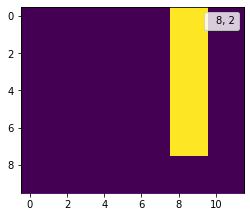

In [6]:
# Single Sample
sample_visualization.fd_im_single_sample(sample=config, label=label, config_dim=config_dim, minmax=(0, 1),
                                         fma=fma, filename="single_sample", directory=directory, figsize=(4, 4));

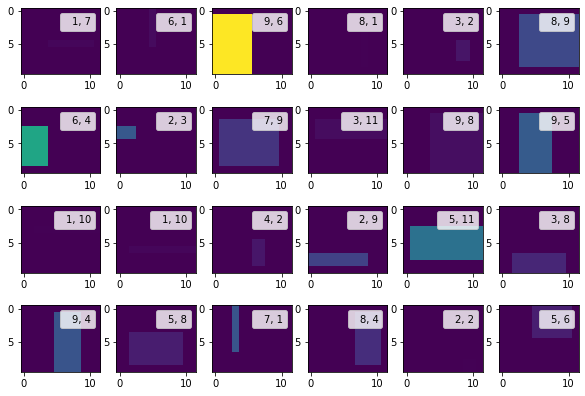

In [7]:
# Batch with labels
sample_visualization.fd_im_batch(batch, batch_labels=batch_label, num_samples=24, dim=(4, 6), config_dim=config_dim,
                                 ab=(batch[:24].cpu().numpy().min(), batch[:24].cpu().numpy().max()), fma=fma, filename="batch", directory=directory, width=3.0);

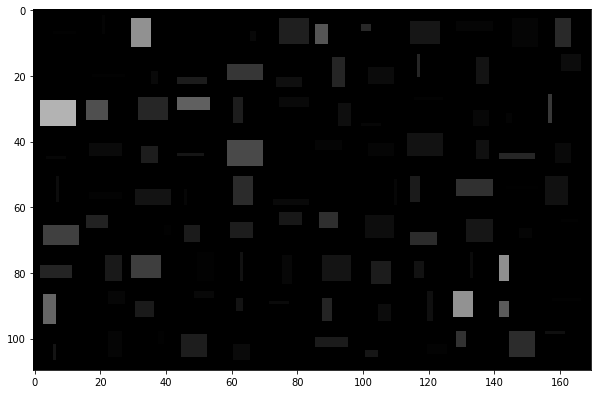

In [8]:
# Batch grid
sample_visualization.fd_im_batch_grid(batch, config_dim=config_dim, ab=(0, 1),
                                      fma=fma, filename="batch_grid", directory=directory);

## pystatplottools.expectation_values - Expectation Values of the Rectangle Dataset

In [9]:
from examples.mock_data import load_characteristics
data = load_characteristics()
data

height  width      mean     color  dx  dy
A                                                
1  0         1      1  0.000112  0.013433   1   6
   1         1      1  0.000083  0.009960   6   4
   2         1      1  0.000096  0.011564   6   2
   3         1      1  0.000009  0.001105  10   8
   4         1      1  0.000060  0.007174   7   2
...        ...    ...       ...       ...  ..  ..
99 519       9     11  0.106885  0.129558   1   0
   520       9     11  0.685258  0.830615   0   1
   521       9     11  0.224127  0.271669   1   0
   522       9     11  0.036274  0.043969   1   1
   523       9     11  0.305865  0.370746   1   1

[50000 rows x 6 columns]

The data dataframe contains some characteristics for each sample:
- 'height' and 'width' refer to the the height and width of the rectangle
- 'dx' and 'dy' are the distances in pixels in the horizontal and the vertical direction counted from the left and the top of the sample
- 'mean' is the mean pixel color of the sample
- 'color' refers to the color of the rectangle

The data is sorted based on the area 'A' of the rectangle.

### Expectation Values for each Rectangle Area 'A'

In [10]:
from pystatplottools.expectation_values.expectation_value import ExpectationValue

ep = ExpectationValue(data=data)

# Computes for the given columns the respective expectation values - The expectation values are computed seperately for each area 'A'
ep.compute_expectation_value(columns=["mean", "dx", "dy", "height", "width"],
                             exp_values=["mean", "max", "min", "secondmoment", "fourthmoment"])

expectation_values = ep.expectation_values
expectation_values

mean                                                            dx  \
        mean       max           min  secondmoment  fourthmoment      mean   
A                                                                            
1   0.000110  0.000819  6.166391e-08  3.155548e-08  8.930643e-15  5.671610   
2   0.000323  0.003255  1.180375e-07  2.942489e-07  1.079140e-12  5.213098   
3   0.000689  0.007286  2.103716e-07  1.441640e-06  2.918677e-11  4.956957   
4   0.001115  0.012805  1.434028e-07  3.757521e-06  2.080737e-10  4.748652   
5   0.001744  0.020064  1.251147e-07  1.027091e-05  1.688186e-09  4.296154   
6   0.002058  0.028719  3.763841e-07  1.376789e-05  3.385040e-09  4.529705   
7   0.003287  0.037385  2.948360e-06  3.529978e-05  1.862360e-08  3.958000   
8   0.003491  0.048993  8.732763e-07  3.830956e-05  2.467506e-08  4.115774   
9   0.004739  0.064618  1.716977e-06  7.511081e-05  1.131680e-07  3.783926   
10  0.003824  0.041080  2.784641e-06  4.008474e-05  2.402887e-08  3.098077   
11  0.003484  0.009153  1.286327e-05  1.811785e-05  7.977245e-10  0.479853   
12  0.005639  0.056693  5.551346e-06  8.127519e-05  6.901690e-08  4.090364   
14  0.008509  0.081205  6.381273e-06  2.221453e-04  6.533550e-07  3.735537   
15  0.007637  0.060625  4.494812e-06  1.330006e-04  1.322640e-07  4.002938   
16  0.009405  0.102542  5.705893e-06  2.474025e-04  9.637492e-07  3.705462   
18  0.012478  0.134247  6.948659e-06  4.289288e-04  2.439602e-06  3.414786   
20  0.011386  0.082872  4.808985e-06  2.707317e-04  5.585594e-07  2.927236   
21  0.014164  0.121634  3.436083e-07  5.085366e-04  2.911152e-06  3.489022   
22  0.013960  0.036467  2.578236e-05  2.873646e-04  2.013652e-07  0.507968   
24  0.018154  0.145899  3.523089e-06  7.671642e-04  4.935008e-06  3.301625   
25  0.018990  0.104157  9.332747e-05  7.811294e-04  3.843824e-06  3.418972   
27  0.021084  0.189907  5.123325e-05  1.015425e-03  1.185540e-05  3.107180   
28  0.020825  0.161152  7.768287e-05  9.202018e-04  7.196694e-06  3.340771   
30  0.022870  0.147360  7.825640e-06  1.112510e-03  8.713738e-06  2.575758   
32  0.028836  0.208155  6.774327e-05  1.879825e-03  2.931937e-05  3.013105   
33  0.030794  0.082387  2.245288e-05  1.433796e-03  5.029328e-06  0.487037   
35  0.031406  0.195061  1.244059e-05  2.031091e-03  2.606480e-05  3.084592   
36  0.035727  0.266910  6.075447e-05  2.768459e-03  5.775963e-05  2.852568   
40  0.042853  0.264747  1.248609e-04  3.594489e-03  7.162158e-05  2.177104   
42  0.044920  0.236728  1.024940e-06  4.046510e-03  8.951871e-05  2.764818   
44  0.054057  0.146139  9.140398e-04  4.245610e-03  4.259039e-05  0.509278   
45  0.050390  0.315183  2.520497e-06  5.074324e-03  1.627056e-04  2.598796   
48  0.056818  0.315041  1.298207e-04  6.458461e-03  2.253694e-04  2.507812   
49  0.053172  0.281438  1.773059e-04  5.466735e-03  1.588857e-04  2.649899   
50  0.065777  0.207084  2.240128e-04  7.049483e-03  1.483424e-04  0.991718   
54  0.075601  0.402520  8.020465e-06  1.110286e-02  6.098716e-04  2.213813   
55  0.083341  0.228227  4.016731e-04  1.049167e-02  2.852949e-04  0.495614   
56  0.077257  0.373042  1.605133e-04  1.058904e-02  5.036205e-04  2.096836   
60  0.097381  0.298486  4.845148e-04  1.503770e-02  6.632197e-04  0.957529   
63  0.090672  0.463294  1.730945e-04  1.524710e-02  1.104719e-03  2.102881   
64  0.101427  0.413727  4.481909e-07  1.863353e-02  1.509403e-03  2.016575   
66  0.129269  0.329954  1.629008e-04  2.450505e-02  1.416239e-03  0.515873   
70  0.122046  0.406810  1.357904e-03  2.409970e-02  1.845010e-03  0.964143   
72  0.122954  0.533463  8.370629e-04  2.758650e-02  3.270320e-03  1.771211   
77  0.165687  0.445729  2.386377e-04  4.035160e-02  3.962381e-03  0.493282   
80  0.158253  0.533199  1.042970e-04  4.151349e-02  5.579734e-03  1.022822   
81  0.159631  0.603698  2.215220e-04  4.282555e-02  6.815001e-03  1.505030   
88  0.209158  0.586310  1.409652e-04  6.497750e-02  1.056077e-02  0.509514   
90  0.202955  0.669956  1.1637

### Expectation Values for all Rectangle Areas 'A'

In [11]:
# Expectation values over entire dataset - drop 'A' dependence and compute the same for the entire dataset - summarized as one dataframe df
from pystatplottools.utils.utils import drop_index_level
ep_all_data = ExpectationValue(data=drop_index_level(data=data, single_key="df"))
ep_all_data.compute_expectation_value(columns=["mean", "dx", "dy", "height", "width"],
                                      exp_values=["mean", "max", "min", "secondmoment", "fourthmoment"])
expectation_values_all_data = ep_all_data.expectation_values
expectation_values_all_data.transpose()

df
mean   mean          3.872881e-02
       max           7.412261e-01
       min           6.166391e-08
       secondmoment  6.956690e-03
       fourthmoment  9.257431e-04
dx     mean          2.991680e+00
       max           1.100000e+01
       min           0.000000e+00
       secondmoment  1.626004e+01
       fourthmoment  8.417909e+02
dy     mean          2.492140e+00
       max           9.000000e+00
       min           0.000000e+00
       secondmoment  1.135042e+01
       fourthmoment  4.089183e+02
height mean          5.004580e+00
       max           9.000000e+00
       min           1.000000e+00
       secondmoment  3.171638e+01
       fourthmoment  1.706662e+03
width  mean          6.010900e+00
       max           1.100000e+01
       min           1.000000e+00
       secondmoment  4.610494e+01
       fourthmoment  3.640053e+03

### Visualization

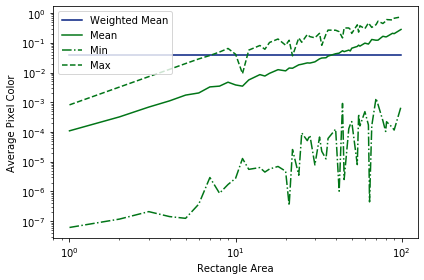

In [12]:
# Visualization of the average pixel color as a function the rectangle area 'A'
fig, ax = fma.newfig(1.0)

rectangle_areas = expectation_values.index.values
mean_all_data = expectation_values_all_data["mean"]["mean"].iloc[0]
ax.plot([rectangle_areas[0], rectangle_areas[-1]], [mean_all_data, mean_all_data], label="Weighted Mean")

ax.plot(rectangle_areas, expectation_values["mean"]["mean"], label="Mean")
ax.plot(rectangle_areas, expectation_values["mean"]["min"], color="C{}".format(1), ls="-.", label="Min")
ax.plot(rectangle_areas, expectation_values["mean"]["max"], color="C{}".format(1), ls="--", label="Max")

ax.legend()
ax.set_xlabel("Rectangle Area")
ax.set_ylabel("Average Pixel Color")
ax.set_xscale("log")
ax.set_yscale("log")
plt.tight_layout()

fma.savefig(directory, "image_mean_over_rectangle_area")

## pystatplottools.distributions - Computation of (Probability) Distributions

### distributions.marginal_distribution - Marginal Distributions / 1D Distributions

In [13]:
from pystatplottools.distributions.marginal_distribution import MarginalDistribution

marginal_distribution = MarginalDistribution(data=data)

range_min, range_max = marginal_distribution.extract_min_max_range_values(["height", "width", "dx", "dy", "mean",
                                                                           "color"])
marginal_distribution.compute(
    axes_indices=["height", "width", "dx", "dy", "mean", "color"],
    range_min=range_min,
    range_max=range_max,
    nbins=[10, 12, 11, 9, 10, 12],
    statistic='probability',
    bin_scales=['linear', 'linear', 'linear', 'linear', 'logarithmic', 'logarithmic']
)

linearized_marginal_distribution = marginal_distribution.linearize(
    order_by_bin=True,
    bin_alignment="center"
)
linearized_marginal_distribution

bin_num_and_dfs       bin         1         2         3         4         5  \
statistics idx                                                                
height     0     1.400000  1.000000  0.509356  0.501502  0.336927  0.523077   
           1     2.200000  0.000000  0.490644  0.000000  0.330189  0.000000   
           2     3.000000  0.000000  0.000000  0.498498  0.000000  0.000000   
           3     3.800000  0.000000  0.000000  0.000000  0.332884  0.000000   
           4     4.600000  0.000000  0.000000  0.000000  0.000000  0.000000   
...                   ...       ...       ...       ...       ...       ...   
color      7     0.004927  0.351695  0.272349  0.200200  0.181267  0.166346   
           8     0.015669  0.313559  0.417879  0.405405  0.375337  0.344231   
           9     0.049825  0.116525  0.144491  0.219219  0.271563  0.307692   
           10    0.158441  0.010593  0.030146  0.058058  0.072102  0.086538   
           11    0.503834  0.000000  0.000000  0.003003  0.009434  0.019231   

bin_num_and_dfs         6      7         8         9  ...        64        66  \
statistics idx                                        ...                       
height     0     0.250624  0.484  0.247467  0.332675  ...  0.000000  0.000000   
           1     0.249626  0.000  0.242644  0.000000  ...  0.000000  0.000000   
           2     0.244633  0.000  0.000000  0.327404  ...  0.000000  0.000000   
           3     0.000000  0.000  0.253739  0.000000  ...  0.000000  0.000000   
           4     0.000000  0.000  0.000000  0.000000  ...  0.000000  0.000000   
...                   ...    ...       ...       ...  ...       ...       ...   
color      7     0.146281  0.130  0.116257  0.096179  ...  0.014733  0.017857   
           8     0.383924  0.316  0.338157  0.311594  ...  0.051565  0.031746   
           9     0.294059  0.327  0.339604  0.369565  ...  0.248619  0.154762   
           10    0.091862  0.131  0.124457  0.152174  ...  0.488029  0.466270   
           11    0.014478  0.032  0.025567  0.031621  ...  0.191529  0.317460   

bin_num_and_dfs        70        72        77        80        81        88  \
statistics idx                                                                
height     0     0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
           1     0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
           2     0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
           3     0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
           4     0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
...                   ...       ...       ...       ...       ...       ...   
color      7     0.015936  0.020019  0.019194  0.016598  0.012072  0.010571   
           8     0.055777  0.057197  0.024952  0.041494  0.030181  0.044397   
           9     0.191235  0.211630  0.143954  0.174274  0.179074  0.122622   
           10    0.474104  0.503337  0.416507  0.443983  0.480885  0.380550   
           11    0.260956  0.205910  0.389635  0.307054  0.287726  0.439746   

bin_num_and_dfs        90        99  
statistics idx                       
height     0     0.000000  0.000000  
           1     0.000000  0.000000  
           2     0.000000  0.000000  
           3     0.000000  0.000000  
           4     0.000000  0.000000  
...                   ...       ...  
color      7     0.001938  0.003817  
           8     0.038760  0.030534  
           9     0.120155  0.108779  
           10    0.482558  0.314885  
           11    0.346899  0.536260  

[64 rows x 51 columns]

### Visualization as Histograms

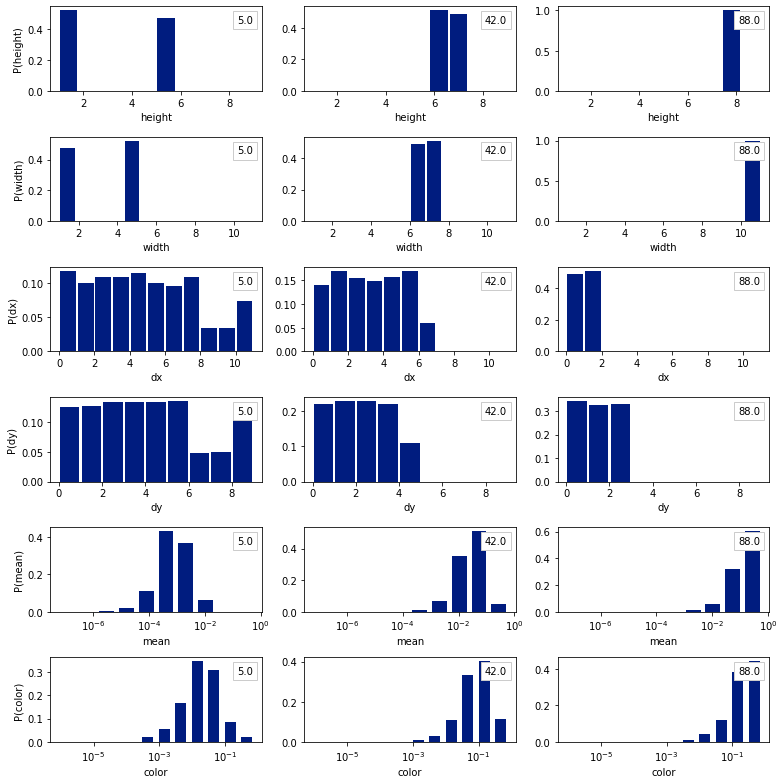

In [14]:
from pystatplottools.utils.bins_and_alignment import revert_align_bins

areas = [5, 42, 88]

fig, axes = fma.newfig(1.8, nrows=6, ncols=3, ratio=1.0, figsize=(11, 11))
for i, area in enumerate(areas):
    for j, (observable, bin_scale) in enumerate(zip(["height", "width", "dx", "dy", "mean", "color"],
                                                    ['linear', 'linear', 'linear', 'linear', 'logarithmic',
                                                     'logarithmic'])):
        binedges = revert_align_bins(
            data_range=linearized_marginal_distribution.loc[observable]["bin"].values,
            bin_alignment="center",
            bin_scale=bin_scale
        )
        if bin_scale == "logarithmic":
            width = 0.6 * (binedges[1:] - binedges[:-1])
            axes[j][i].set_xscale("log")
        else:
            width = 0.9 * (binedges[1:] - binedges[:-1])

        axes[j][i].bar(
            x=linearized_marginal_distribution.loc[observable]["bin"].values,
            height=linearized_marginal_distribution.loc[observable][area].values,
            width=width
        )
        axes[j][i].set_xlabel(observable)
        from pystatplottools.visualization.utils import add_fancy_legend_box
        add_fancy_legend_box(ax=axes[j][i], name=float(area))

for j, observable in enumerate(["height", "width", "dx", "dy", "mean", "color"]):
    axes[j][0].set_ylabel("P(" + observable + ")")
        
# ax.set_xlabel("Rectangle Area")
# ax.set_ylabel("Average Pixel Color")

plt.tight_layout()

fma.savefig(directory, "marginal_distributions")

### distributions.joint_distribution - Joint Distributions

In [15]:
from pystatplottools.distributions.joint_distribution import JointDistribution

joint_distribution = JointDistribution(data=data)

range_min, range_max = joint_distribution.extract_min_max_range_values(["dx", "dy", "mean"])

joint_distribution.compute(
    axes_indices=["dx", "dy", "mean"],
    range_min=range_min,
    range_max=range_max,
    nbins=[11, 9, 10],
    statistic="probability"
)

# Internally a multidimensional histogram is computed with np.histogram() for each rectangle area.
# The histograms can be accessed via: joint_distribution.distribution or linearized.

# Transforms joint_distribution into a linear list of mid boundaries for the different bins
# and the respective statistics for the values
linearized_joint_distribution = joint_distribution.linearize(
    output_statistics_name="prob",
    dataframes_as_columns=False,
    bin_alignment="center"
)
linearized_joint_distribution

axes_and_statistics    dx   dy      mean      prob
dfs idx                                           
1   0                 0.5  0.5  0.037061  0.014831
    1                 0.5  0.5  0.111184  0.000000
    2                 0.5  0.5  0.185307  0.000000
    3                 0.5  0.5  0.259429  0.000000
    4                 0.5  0.5  0.333552  0.000000
...                   ...  ...       ...       ...
99  985              10.5  8.5  0.407674  0.000000
    986              10.5  8.5  0.481797  0.000000
    987              10.5  8.5  0.555920  0.000000
    988              10.5  8.5  0.630042  0.000000
    989              10.5  8.5  0.704165  0.000000

[49500 rows x 4 columns]

### pystatplottools.plotting.contour2D - Visualization of a 2D Joint Distribution

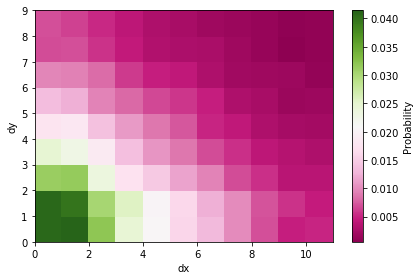

In [16]:
# Preparation - Merge all areas
from pystatplottools.utils.utils import drop_index_level
data_all = drop_index_level(data=data, single_key="df")
from pystatplottools.distributions.joint_distribution import JointDistribution

joint_distribution = JointDistribution(data=data_all)

range_min, range_max = list(map(list, data_all[["dx", "dy"]].agg(["min", "max"]).values))
joint_distribution.compute(
    axes_indices=["dx", "dy"],
    range_min=range_min,
    range_max=range_max,
    nbins=[11, 9],
    statistic='probability'
)

linearized_joint_distribution = joint_distribution.linearize(output_statistics_name="prob")

# Contour plot
fig, ax = fma.newfig(1.4)

from pystatplottools.plotting.contour2D import Contour2D

contour2D = Contour2D(
    ax=ax,
    data=linearized_joint_distribution.loc["df"],
    x="dx",  # possibility to rescale x and y axis or perform other operation for x axis
    # like computing a mass difference
    y="dy",
    z_index="prob"
)

contour2D.set_ax_labels(x_label="dx", y_label="dy")
cf = contour2D.pcolormesh(
    cbar_scale="Lin",
    lev_num=40,
    cmap="PiYG"
)
contour2D.add_colorbar(fig=fig, cf=cf, z_label="Probability")

plt.tight_layout()
fma.savefig(directory, "probability_colormesh")

### distributions.binned_statistics - Computation of Binned Statistics

Computing and Visualizing mean for different values of (dx, height)

In [17]:
# Preparation - Merge all areas
from pystatplottools.utils.utils import drop_index_level
data_all = drop_index_level(data=data, single_key="df")

from pystatplottools.distributions.binned_statistics import BinnedStatistics

binned_statistics = BinnedStatistics(data=data_all)

range_min, range_max = list(map(list, data_all[["dx", "height"]].agg(["min", "max"]).values))
binned_statistics.compute(
    axes_indices=["dx", "height"],
    columns=["mean", "color"],
    range_min=range_min,
    range_max=range_max,
    nbins=[11, 8],
    statistic='mean'
)

linearized_statistics = binned_statistics.linearize(
    output_statistics_names=["mean", "color"],
    dataframes_as_columns=False,
    bin_alignment="center"
)
linearized_statistics

axes_and_statistics    dx  height      mean     color
dfs idx                                              
df  0                 0.5     1.5  0.003159  0.049090
    1                 0.5     2.5  0.013339  0.102492
    2                 0.5     3.5  0.028674  0.148589
    3                 0.5     4.5  0.051009  0.198826
    4                 0.5     5.5  0.078890  0.249342
...                   ...     ...       ...       ...
    83               10.5     4.5  0.000703  0.015166
    84               10.5     5.5  0.001317  0.022678
    85               10.5     6.5  0.001856  0.028520
    86               10.5     7.5  0.002498  0.032564
    87               10.5     8.5  0.003467  0.036937

[88 rows x 4 columns]

### Visualization of Binned Statistics with a Logarithmic Colorbar

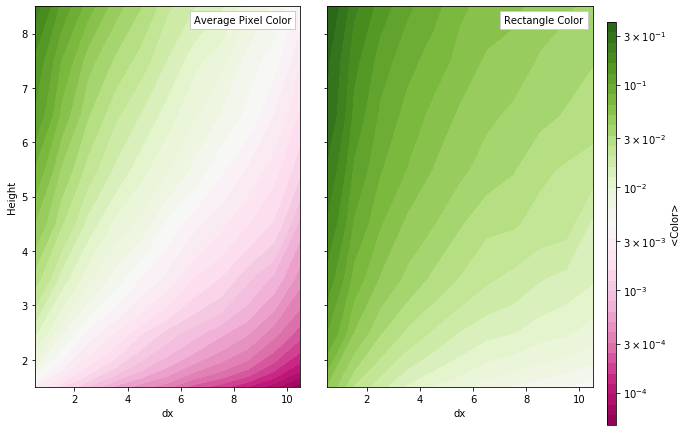

In [18]:
# Contour plot
fig, ax = fma.newfig(1.4, figsize=(10, 7), ratio=0.5, nrows=1, ncols=2)

# Preparation
from pystatplottools.plotting.contour2D import Contour2D

contour2D_mean = Contour2D(
    ax=ax[0],
    data=linearized_statistics.loc["df"],
    x="dx",
    y="height",
    z_index="mean"
)

contour2D_color = Contour2D(
    ax=ax[1],
    data=linearized_statistics.loc["df"],
    x="dx",
    y="height",
    z_index="color"
)

contour2D_mean.set_ax_labels(x_label="dx", y_label="Height")

contour2D_color.set_ax_labels(x_label="dx")
contour2D_color.set_ax_label_visibility(ax[1], y_ticks_visible=False)

lev_min = linearized_statistics[["mean", "color"]].values.min()
lev_max = linearized_statistics[["mean", "color"]].values.max()
norm, levs = Contour2D.get_log_norm_and_levs(lev_min=lev_min, lev_max=lev_max, lev_num=40)

contour2D_mean.contourf(
    norm=norm,
    levs=levs,
    cmap="PiYG"
)
contour2D_mean.add_fancy_box("Average Pixel Color")

cf = contour2D_color.contourf(
    norm=norm,
    levs=levs,
    cmap="PiYG"
)
contour2D_color.add_fancy_box("Rectangle Color")

fig.subplots_adjust(wspace=0.1, right=0.9)
cbar_ax = fig.add_axes([0.92, 0.05, 0.012, 0.8])

Contour2D.add_colorbar(
    fig=fig, cf=cf,
    z_label="<Color>",
    cax=cbar_ax,
    z_ticks=[1e-4, 3e-4, 1e-3, 3e-3, 1e-2, 3e-2, 1e-1, 3e-1],
    z_tick_labels=['$10^{-4}$', '$3\\times10^{-4}$', '$10^{-3}$', '$3\\times10^{-3}$', '$10^{-2}$',
                   '$3\\times10^{-2}$', '$10^{-1}$', '$3\\times10^{-1}$']
)

fma.savefig(directory, "mean_colormesh")

### distributions.sparse_joint_distribution - Computation of Joint Distributions in High Dimensions and Marginalization

Preparation

In [19]:
# Downsizing dataset samples - Mean value over 2x2 blocks (from 10 x 12 to 5 x 6)
sample_data = data_loader.dataset.data.cpu().numpy().reshape(len(data_loader.dataset), -1)
sample_data = sample_data.reshape(-1, 5, 2, 6, 2).mean(axis=(2, 4)).reshape(len(data_loader.dataset), -1)
import pandas as pd
from pystatplottools.utils.utils import add_index_level
sample_data = add_index_level(data=pd.DataFrame(sample_data), key="df")
sample_data # 30 pixels per sample

0         1         2         3         4         5   \
df 0      0.000000  0.044196  0.044196  0.000000  0.000000  0.000000   
   1      0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
   2      0.000000  0.000000  0.000000  0.012408  0.024815  0.024815   
   3      0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
   4      0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
...            ...       ...       ...       ...       ...       ...   
   49995  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
   49996  0.000000  0.000000  0.000000  0.024391  0.048783  0.048783   
   49997  0.692178  0.692178  0.692178  0.346089  0.000000  0.000000   
   49998  0.377927  0.377927  0.377927  0.377927  0.377927  0.000000   
   49999  0.140873  0.281747  0.281747  0.281747  0.000000  0.000000   

                6         7         8         9   ...        20        21  \
df 0      0.000000  0.088391  0.088391  0.000000  ...  0.000000  0.000000   
   1      0.000000  0.000000  0.000000  0.035997  ...  0.000000  0.035997   
   2      0.000000  0.000000  0.000000  0.024815  ...  0.000000  0.024815   
   3      0.222635  0.222635  0.222635  0.222635  ...  0.445270  0.445270   
   4      0.176505  0.176505  0.176505  0.176505  ...  0.353010  0.353010   
...            ...       ...       ...       ...  ...       ...       ...   
   49995  0.000000  0.075907  0.075907  0.000000  ...  0.037953  0.000000   
   49996  0.000000  0.000000  0.000000  0.024391  ...  0.000000  0.000000   
   49997  0.692178  0.692178  0.692178  0.346089  ...  0.692178  0.346089   
   49998  0.377927  0.377927  0.377927  0.377927  ...  0.188963  0.188963   
   49999  0.140873  0.281747  0.281747  0.281747  ...  0.281747  0.281747   

                22        23        24        25        26        27       28  \
df 0      0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.00000   
   1      0.000000  0.000000  0.000000  0.000000  0.000000  0.017998  0.00000   
   2      0.049630  0.049630  0.000000  0.000000  0.000000  0.024815  0.04963   
   3      0.445270  0.222635  0.445270  0.445270  0.445270  0.445270  0.44527   
   4      0.000000  0.000000  0.176505  0.176505  0.176505  0.176505  0.00000   
...            ...       ...       ...       ...       ...       ...      ...   
   49995  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.00000   
   49996  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.00000   
   49997  0.000000  0.000000  0.346089  0.346089  0.346089  0.173045  0.00000   
   49998  0.188963  0.000000  0.000000  0.000000  0.000000  0.000000  0.00000   
   49999  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.00000   

                29  
df 0      0.000000  
   1      0.000000  
   2      0.049630  
   3      0.222635  
   4      0.000000  
...            ...  
   49995  0.000000  
   49996  0.000000  
   49997  0.000000  
   49998  0.000000  
   49999  0.000000  

[50000 rows x 30 columns]

### Computation of a Sparse Joint Distribution in Pixel Space with 10 Bins in each Dimension'.

In [20]:
from pystatplottools.distributions.sparse_joint_distribution import SparseJointDistribution

spare_joint_distribution = SparseJointDistribution(data=sample_data)
range_min, range_max = spare_joint_distribution.extract_min_max_range_values()

spare_joint_distribution.compute(
    statistic="probability",
    transform='lin',
    nbins=[10 for _ in range(len(sample_data.columns))],
    range_min=range_min,
    range_max=range_max,
    bin_scales='linear',
    one_dim_bin_index=False
)

sparse_distribution = spare_joint_distribution.distribution

linearized_sparse_distribution, bin_information = spare_joint_distribution.linearize(order_by_bin=True)

# Data is stored by a vector (bin_0, ..., bin_29) consisting of the bin index in each dimension
linearized_sparse_distribution

bin_num_and_dfs   bin_0  bin_1  bin_2  bin_3  bin_4  bin_5  bin_6  bin_7  \
statistics  idx                                                            
probability 0         0      0      0      0      0      0      0      0   
            1         0      0      0      0      0      0      0      0   
            2         0      0      0      0      0      0      0      0   
            3         0      0      0      0      0      0      0      0   
            4         0      0      0      0      0      0      0      0   
...                 ...    ...    ...    ...    ...    ...    ...    ...   
            2378      9      9      9      9      4      0      9      9   
            2379      9      9      9      9      9      0      9      9   
            2380      9      9      9      9      9      0      9      9   
            2381      9      9      9      9      9      9      9      9   
            2382      9      9      9      9      9      9      9      9   

bin_num_and_dfs   bin_8  bin_9  ...  bin_21  bin_22  bin_23  bin_24  bin_25  \
statistics  idx                 ...                                           
probability 0         0      0  ...       0       0       0       0       0   
            1         0      0  ...       0       0       0       0       0   
            2         0      0  ...       0       0       0       0       0   
            3         0      0  ...       0       0       0       0       0   
            4         0      0  ...       0       0       0       0       0   
...                 ...    ...  ...     ...     ...     ...     ...     ...   
            2378      9      9  ...       9       4       0       4       4   
            2379      9      9  ...       9       9       0       4       4   
            2380      9      9  ...       9       9       0       4       4   
            2381      9      9  ...       9       9       9       4       4   
            2382      9      9  ...       9       9       9       5       5   

bin_num_and_dfs   bin_26  bin_27  bin_28  bin_29       df  
statistics  idx                                            
probability 0          0       0       0       0  0.62786  
            1          0       0       0       1  0.00130  
            2          0       0       1       0  0.00002  
            3          0       1       0       0  0.00002  
            4          0       1       1       0  0.00004  
...                  ...     ...     ...     ...      ...  
            2378       4       5       2       0  0.00002  
            2379       4       4       4       0  0.00014  
            2380       4       5       5       0  0.00002  
            2381       4       4       4       4  0.00020  
            2382       5       5       5       5  0.00002  

[2383 rows x 31 columns]

Possiblity to represent this as a joint distribution with respective bins

In [21]:
linearized_joint_distribution = spare_joint_distribution.linearized_sparse_distribution_to_linearized_joint_distribution(
    linearized_sparse_distribution=linearized_sparse_distribution,
    bin_information=bin_information,
    bin_alignment="center"
)
linearized_joint_distribution

axes_and_dfs             0         1         2         3         4         5  \
statistics  idx                                                                
probability 0     0.044923  0.044923  0.044923  0.044923  0.044923  0.022461   
            1     0.044923  0.044923  0.044923  0.044923  0.044923  0.022461   
            2     0.044923  0.044923  0.044923  0.044923  0.044923  0.022461   
            3     0.044923  0.044923  0.044923  0.044923  0.044923  0.022461   
            4     0.044923  0.044923  0.044923  0.044923  0.044923  0.022461   
...                    ...       ...       ...       ...       ...       ...   
            2378  0.853533  0.853533  0.853533  0.853533  0.404305  0.022461   
            2379  0.853533  0.853533  0.853533  0.853533  0.853533  0.022461   
            2380  0.853533  0.853533  0.853533  0.853533  0.853533  0.022461   
            2381  0.853533  0.853533  0.853533  0.853533  0.853533  0.426767   
            2382  0.853533  0.853533  0.853533  0.853533  0.853533  0.426767   

axes_and_dfs             6         7         8         9  ...        21  \
statistics  idx                                           ...             
probability 0     0.044923  0.044923  0.044923  0.044923  ...  0.044923   
            1     0.044923  0.044923  0.044923  0.044923  ...  0.044923   
            2     0.044923  0.044923  0.044923  0.044923  ...  0.044923   
            3     0.044923  0.044923  0.044923  0.044923  ...  0.044923   
            4     0.044923  0.044923  0.044923  0.044923  ...  0.044923   
...                    ...       ...       ...       ...  ...       ...   
            2378  0.853533  0.853533  0.853533  0.853533  ...  0.853533   
            2379  0.853533  0.853533  0.853533  0.853533  ...  0.853533   
            2380  0.853533  0.853533  0.853533  0.853533  ...  0.853533   
            2381  0.853533  0.853533  0.853533  0.853533  ...  0.853533   
            2382  0.853533  0.853533  0.853533  0.853533  ...  0.853533   

axes_and_dfs            22        23        24        25        26        27  \
statistics  idx                                                                
probability 0     0.044923  0.022461  0.044724  0.044724  0.044724  0.044628   
            1     0.044923  0.022461  0.044724  0.044724  0.044724  0.044628   
            2     0.044923  0.022461  0.044724  0.044724  0.044724  0.044628   
            3     0.044923  0.022461  0.044724  0.044724  0.044724  0.133883   
            4     0.044923  0.022461  0.044724  0.044724  0.044724  0.133883   
...                    ...       ...       ...       ...       ...       ...   
            2378  0.404305  0.022461  0.402520  0.402520  0.402520  0.490906   
            2379  0.853533  0.022461  0.402520  0.402520  0.402520  0.401650   
            2380  0.853533  0.022461  0.402520  0.402520  0.402520  0.490906   
            2381  0.853533  0.426767  0.402520  0.402520  0.402520  0.401650   
            2382  0.853533  0.426767  0.491969  0.491969  0.491969  0.490906   

axes_and_dfs            28        29       df  
statistics  idx                                
probability 0     0.044628  0.022400  0.62786  
            1     0.044628  0.067201  0.00130  
            2     0.133883  0.022400  0.00002  
            3     0.044628  0.022400  0.00002  
            4     0.133883  0.022400  0.00004  
...                    ...       ...      ...  
            2378  0.223139  0.022400  0.00002  
            2379  0.401650  0.022400  0.00014  
            2380  0.490906  0.022400  0.00002  
            2381  0.401650  0.201604  0.00020  
            2382  0.490906  0.246404  0.00002  

[2383 rows x 31 columns]

### Marginalization - Also works for distributions.joint_distribution

In [22]:
partly_marginalized_distribution = spare_joint_distribution.marginalize(
    initial_axes_indices=list(range(30)), remaining_axes_indices=list(range(5)), data=linearized_joint_distribution)

partly_marginalized_distribution

axes_and_dfs            0         1         2         3         4       df
statistics  idx                                                           
probability 0    0.044923  0.044923  0.044923  0.044923  0.044923  0.86040
            1    0.044923  0.044923  0.044923  0.044923  0.134768  0.00062
            2    0.044923  0.044923  0.044923  0.134768  0.044923  0.00144
            3    0.044923  0.044923  0.044923  0.134768  0.134768  0.00242
            4    0.044923  0.044923  0.134768  0.044923  0.044923  0.00288
...                   ...       ...       ...       ...       ...      ...
            122  0.853533  0.853533  0.853533  0.044923  0.044923  0.00002
            123  0.853533  0.853533  0.853533  0.404305  0.044923  0.00006
            124  0.853533  0.853533  0.853533  0.853533  0.044923  0.00014
            125  0.853533  0.853533  0.853533  0.853533  0.404305  0.00012
            126  0.853533  0.853533  0.853533  0.853533  0.853533  0.00038

[127 rows x 6 columns]

### Verify if the computed marginal distribution is correct

In [23]:
# Verify marginal distribution

part_spare_joint_distribution = SparseJointDistribution(data=sample_data[list(range(5))])
part_range_min, part_range_max = part_spare_joint_distribution.extract_min_max_range_values()

part_sparse_distribution = part_spare_joint_distribution.compute(
    statistic="probability",
    transform='lin',
    nbins=[10 for _ in range(5)],
    range_min=part_range_min,
    range_max=part_range_max,
    bin_scales='linear'
)

linearized_part_sparse_distribution, part_bin_information = part_spare_joint_distribution.linearize(order_by_bin=True)

linearized_part_joint_distribution = part_spare_joint_distribution.linearized_sparse_distribution_to_linearized_joint_distribution(
    linearized_sparse_distribution=linearized_part_sparse_distribution,
    bin_information=part_bin_information,
    bin_alignment="center"
)

# assert np.sum(partly_marginalized_distribution.values - linearized_part_joint_distribution.values) < 1e-10, \
#     "Distributions do not coincide"

linearized_part_joint_distribution

axes_and_dfs            0         1         2         3         4       df
statistics  idx                                                           
probability 0    0.044923  0.044923  0.044923  0.044923  0.044923  0.86040
            1    0.044923  0.044923  0.044923  0.044923  0.134768  0.00062
            2    0.044923  0.044923  0.044923  0.134768  0.044923  0.00144
            3    0.044923  0.044923  0.044923  0.134768  0.134768  0.00242
            4    0.044923  0.044923  0.134768  0.044923  0.044923  0.00288
...                   ...       ...       ...       ...       ...      ...
            122  0.853533  0.853533  0.853533  0.044923  0.044923  0.00002
            123  0.853533  0.853533  0.853533  0.404305  0.044923  0.00006
            124  0.853533  0.853533  0.853533  0.853533  0.044923  0.00014
            125  0.853533  0.853533  0.853533  0.853533  0.404305  0.00012
            126  0.853533  0.853533  0.853533  0.853533  0.853533  0.00038

[127 rows x 6 columns]

In [24]:
# Check whether partly_marginalized_distribution and linearized_part_joint_distribution are the same
np.sum(partly_marginalized_distribution.values - linearized_part_joint_distribution.values)

3.3493105749786423e-15